# Parallel Wrapper Evaluation

## Environment

### Imports

In [1]:
import sys
sys.path.append('/home/vincenzoscotti/Projects/transformer_wrappers/src')

In [2]:
import os
import itertools
from datetime import datetime
import json
import yaml
import pandas as pd
import hashlib

In [3]:
import torch

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig, TrainingArguments
from datasets import Dataset
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from peft import AutoPeftModelForCausalLM, AutoPeftModelForSeq2SeqLM
from trl import SFTTrainer

/home/vincenzoscotti/anaconda3/envs/trwrap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-30 10:29:23.996594: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 10:29:24.019877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 10:29:24.603661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could no

In [5]:
from transformer_wrappers.wrappers import ResizableCausalLMWrapper, CausalLMWrapper
from transformer_wrappers.wrappers.resizable import ResizableTokenizer

In [6]:
from transformer_wrappers.data import OpenAssistantGuanaco

In [7]:
import lm_eval

In [8]:
from typing import List, Dict

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants and globals

In [10]:
TOKEN = None  # HF Token

In [11]:
EXPERIMENTS_DIR_PATH: str = '/home/vincenzoscotti/Projects/transformer_wrappers/experiments'
EXPERIMENT_SERIES_ID: str = 'resizable_wrapper'

In [12]:
BENCHMARKS: List[str] = ['hellaswag', 'winogrande', 'truthfulqa_mc1', 'gsm8k', 'arc_challenge', 'mmlu']

In [13]:
BATCH_SIZE: int = 8

In [14]:
MODEL = 'mistralai/Mistral-7B-Instruct-v0.2'  
# MODEL = 'meta-llama/Llama-2-7b-hf'
# MODEL = 'google/gemma-7b'
MODEL_CONFIGS = {
    'torch_dtype': torch.bfloat16,
    'device_map': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'token': TOKEN
}
QUANTIZATION_CONFIGS = {
    'load_in_4bit': True,
    'bnb_4bit_use_double_quant': True, 
    'bnb_4bit_quant_type': 'nf4', 
    'bnb_4bit_compute_dtype': torch.bfloat16
}
TOKENIZER = MODEL
TOKENIZER_CONFIGS = {'token': TOKEN, 'pad_token': '</s>'}
WRAPPER_CONFIGS_KEYS: List[str] = ['max_token_len']
WRAPPER_CONFIGS_VALUES: List[str] = [[1, 2, 3, 4, 5, 6, 7, 8, None]]

In [36]:
LORA_CONFIGS = {
    'lora_alpha': 16,
    'lora_dropout': 0.1,
    'r': 16,
    # 'bias': None,
    'task_type': 'CAUSAL_LM'
}
TRAINING_ARGS = {
    'num_train_epochs': 3,
    'per_device_train_batch_size': 1,
    # 'gradient_accumulation_steps': 32,
    'gradient_checkpointing': True,
    'optim': 'paged_adamw_32bit',
    'logging_steps': 50,
    'report_to': 'tensorboard',
    'save_strategy': 'epoch',
    'evaluation_strategy': 'epoch',
    'load_best_model_at_end': True,
    'learning_rate': 2.e-5,
    'bf16': True,
    'tf32': True,
    'max_grad_norm': 1.0,
    'warmup_ratio': 0.03,
    'lr_scheduler_type': 'cosine',
    # 'disable_tqdm': True
}

In [16]:
if not os.path.exists(EXPERIMENTS_DIR_PATH):
    os.mkdir(EXPERIMENTS_DIR_PATH)
if not os.path.exists(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID)):
    os.mkdir(os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID))

current_experiments_dir = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, MODEL.replace('/', '-'))
if not os.path.exists(current_experiments_dir):
    os.mkdir(current_experiments_dir)

### Helper functions

In [17]:
def get_configs_hash(configs):
    return hashlib.sha256(str(configs).encode()).hexdigest()

In [18]:
def append_results(**kwargs):
    file_path = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, 'results.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = pd.concat([df, pd.DataFrame.from_dict([kwargs])], ignore_index=True)
    else:
        df = pd.DataFrame.from_dict([kwargs])
    df.to_csv(file_path, index=None)

In [19]:
def load_results_df():
    file_path = os.path.join(EXPERIMENTS_DIR_PATH, EXPERIMENT_SERIES_ID, 'results.csv')
    return pd.read_csv(file_path, index=False)

In [20]:
def save_results(results, configs, benchmark):
    # Create dir (if necessary)
    dir_path = os.path.join(current_experiments_dir, get_configs_hash(configs))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    # Save configs (if necessary)
    configs_file_path = os.path.join(dir_path, 'configs.yml')
    if not os.path.exists(configs_file_path):
        with open(configs_file_path, 'w') as f:
            yaml.dump(configs, f)
    # Save results
    file_path = os.path.join(dir_path, f'{benchmark}.json')
    with open(file_path, 'w') as f:
        json.dump({k: results[k] for k in results if k!='config'}, f)
    # Append results to main CSV
    append_results(model=MODEL, benchmark=benchmark, **results['results'][benchmark], **configs)

In [21]:
def check_results_exist(configs, benchmark):
    dir_path = os.path.join(current_experiments_dir, get_configs_hash(configs))
    file_path = os.path.join(dir_path, f'{benchmark}.json')
    
    return os.path.exists(file_path)

In [43]:
def setup_fine_tuning(configs):
    # Create dir (if necessary)
    dir_path = os.path.join(current_experiments_dir, f'FT-{get_configs_hash(configs)}')
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    istance_dir_path = os.path.join(current_experiments_dir, datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))
    os.mkdir(istance_dir_path)
    os.mkdir(os.path.join(istance_dir_path, 'logs'))
    # Save configs (if necessary)
    configs_file_path = os.path.join(istance_dir_path, 'configs.yml')
    with open(configs_file_path, 'w') as f:
        yaml.dump(
            {
                'wrapper_configs': configs, 
                'model': MODEL, 
                'model_configs': {k: v if k not in {'torch_dtype', 'device_map'} else str(v) for k, v in MODEL_CONFIGS.items()},
                'quantization_configs': {k: v if k != 'bnb_4bit_compute_dtype' else str(v) for k, v in QUANTIZATION_CONFIGS.items()},
                'tokenizer': TOKENIZER,
                'tokenizer_configs': TOKENIZER_CONFIGS,
                'lora_configs': LORA_CONFIGS,
                'training_args': TRAINING_ARGS
            }, 
            f
        )

    return istance_dir_path

In [23]:
def save_fine_tuning_results(results, configs, benchmark, istance_dir_path):
    # Save results
    file_path = os.path.join(istance_dir_path, f'{benchmark}.json')
    with open(file_path, 'w') as f:
        json.dump({k: results[k] for k in results if k!='config'}, f)
    # Append results to main CSV
    append_results(model=MODEL, benchmark=benchmark, **results['results'][benchmark], **configs)

## Experiment:

### Model

Load model

In [19]:
model = ResizableCausalLMWrapper.from_pretrained(
# model = CausalLMWrapper.from_pretrained(
    MODEL, 
    model_kwargs=MODEL_CONFIGS,
    tokenizer_kwargs=TOKENIZER_CONFIGS
)
model.enable_benchmarking()

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.76it/s]


### Evaluation

In [20]:
experiment_configs: List[Dict] = [
    {k: v for k, v in zip(WRAPPER_CONFIGS_KEYS, configs)}
    for configs in itertools.product(*WRAPPER_CONFIGS_VALUES)
]

In [ ]:
# Iterate over benchmarks
for benchmark in BENCHMARKS:
    print("# Benchmark")
    # Iterate over configs
    for configs in experiment_configs:
        print(f"## Configs: {configs}")
        # Run evaluation (if results are not avaialble yet)
        if not check_results_exist(configs, benchmark):
            # Set attribute values  # TODO fixme
            for k, v in configs.items():
                setattr(model, k, v)
            # Run evaluation
            results = lm_eval.simple_evaluate(
                model="hf",
                model_args={'pretrained': model, 'tokenizer': model.tokenizer, 'backend': 'causal'},
                # model_args='pretrained=mistralai/Mistral-7B-Instruct-v0.2,attn_implementation=eager,device_map=cuda',
                tasks=[benchmark],
                batch_size=BATCH_SIZE,
                # log_samples=True,
            )
            # Save results
            save_results(results, configs, benchmark)

2024-04-30:00:16:27,152 INFO     [evaluator.py:129] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234
2024-04-30:00:16:27,155 WARNING  [huggingface.py:118] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-04-30:00:16:27,211 INFO     [huggingface.py:414] Overrode HF model backend type, and using type 'causal'
2024-04-30:00:16:27,323 WARNING  [huggingface.py:337] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration


# Benchmark
## Configs: {'max_token_len': 1}


2024-04-30:00:16:29,878 INFO     [evaluator.py:190] get_task_dict has been updated to accept an optional argument, `task_manager`Read more here:https://github.com/EleutherAI/lm-evaluation-harness/blob/main/docs/interface.md#external-library-usage
/home/vincenzoscotti/anaconda3/envs/trwrap/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
2024-04-30:00:16:35,716 INFO     [task.py:395] Building contexts for hellaswag on rank 0...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10042/10042 [00:01<00:00, 7688.49it/s]
2024

## Fine-tuning

In [24]:
configs = {'max_token_len': 1, 'fine_tuning': True}

### Model

Load model

In [26]:
model = AutoModelForCausalLM.from_pretrained(MODEL, **MODEL_CONFIGS, **QUANTIZATION_CONFIGS)
tokenizer = ResizableTokenizer(AutoTokenizer.from_pretrained(TOKENIZER, **TOKENIZER_CONFIGS), max_token_len=1)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]


Adapters

In [37]:
lora_configs = LoraConfig(**LORA_CONFIGS)

In [38]:
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_configs)

### Data

In [39]:
data_splits = {
    split: OpenAssistantGuanaco(split, tokenizer)
    for split in ['train', 'validation', 'test']
}

Repo card metadata block was not found. Setting CardData to empty.
2024-04-30:10:31:20,949 WARNING  [repocard.py:107] Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
2024-04-30:10:31:33,363 WARNING  [repocard.py:107] Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.
2024-04-30:10:31:37,156 WARNING  [repocard.py:107] Repo card metadata block was not found. Setting CardData to empty.


### Training

In [44]:
fine_tuning_dir = setup_fine_tuning(configs)

Trainer args

In [45]:
training_args = TrainingArguments(
    output_dir=os.path.join(fine_tuning_dir, 'logs'),
    logging_dir=os.path.join(fine_tuning_dir, 'logs'),
    **TRAINING_ARGS
)

Trainer

In [ ]:
q_trainer = SFTTrainer(
    model=model,
    train_dataset=Dataset.from_dict({'text': data_splits['train'].data}),
    eval_dataset=Dataset.from_dict({'text': data_splits['validation'].data}),
    peft_config=lora_configs,
    max_seq_length=2048,
    tokenizer=tokenizer,
    args=training_args,
    # data_collator=data_splits['train'].huggingface_collate
    # formatting_func=lambda x: x['text']
    dataset_text_field='text'
)

Map:  11%|██████████▋                                                                                    | 1000/8861 [00:16<02:08, 61.15 examples/s]

In [ ]:
q_trainer.train()
q_trainer.save_model()

In [ ]:
q_trainer.eval()

### Evaluation

In [ ]:
# Iterate over benchmarks
for benchmark in BENCHMARKS:
    print("# Benchmark")
    # Run evaluation
    results = lm_eval.simple_evaluate(
        model="hf",
        model_args={'pretrained': model, 'tokenizer': tokenizer, 'backend': 'causal'},
        # model_args='pretrained=mistralai/Mistral-7B-Instruct-v0.2,attn_implementation=eager,device_map=cuda',
        tasks=[benchmark],
        batch_size=BATCH_SIZE,
        # log_samples=True,
    )
    # Save results
    save_fine_tuning_results(results, configs, benchmark, fine_tuning_dir)

## Results

Gather experiments results

In [27]:
results_df = load_results_df()
results_df

,benchmark,score,model,p_rate,block_parallel,iterative,average,compensate_avg
0,hellaswag,0.774248,mistralai/Mistral-7B-Instruct-v0.2,2,False,True,False,False
1,hellaswag,0.261103,mistralai/Mistral-7B-Instruct-v0.2,4,True,False,False,False
2,hellaswag,0.523302,mistralai/Mistral-7B-Instruct-v0.2,4,True,True,True,False
3,hellaswag,0.445330,mistralai/Mistral-7B-Instruct-v0.2,4,True,True,False,False
4,hellaswag,0.746764,mistralai/Mistral-7B-Instruct-v0.2,2,True,True,True,True
5,hellaswag,0.263195,mistralai/Mistral-7B-Instruct-v0.2,2,True,False,True,True
6,hellaswag,0.268572,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,False,False
7,hellaswag,0.262199,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,True,False
8,hellaswag,0.268672,mistralai/Mistral-7B-Instruct-v0.2,2,False,False,True,True
9,hellaswag,0.780223,mistralai/Mistral-7B-Instruct-v0.2,2,True,True,False,False


In [31]:
null_acc_norm_mask = results_df['acc_norm,none'].isnull()
null_acc_norm_mask
results_df['accuracy'] = results_df['acc,none']
results_df.loc[~null_acc_norm_mask, 'accuracy'] = results_df[~null_acc_norm_mask]['acc_norm,none'].values

null_max_token_len_mask = results_df['max_token_len'].isnull()
null_max_token_len_mask
results_df.loc[null_max_token_len_mask, 'max_token_len'] = 5
results_df['max_token_len'] = results_df['max_token_len'].astype(int)

results_df

,model,benchmark,"acc,none","acc_stderr,none","acc_norm,none","acc_norm_stderr,none",alias,max_token_len,accuracy
0,mistralai/Mistral-7B-Instruct-v0.2,hellaswag,0.327325,0.004683,0.435371,0.004948,hellaswag,1,0.435371
1,mistralai/Mistral-7B-Instruct-v0.2,hellaswag,0.383489,0.004852,0.576280,0.004931,hellaswag,2,0.576280
2,mistralai/Mistral-7B-Instruct-v0.2,hellaswag,0.397929,0.004885,0.636029,0.004802,hellaswag,3,0.636029
3,mistralai/Mistral-7B-Instruct-v0.2,hellaswag,0.431488,0.004943,0.654949,0.004744,hellaswag,4,0.654949
4,mistralai/Mistral-7B-Instruct-v0.2,hellaswag,0.659331,0.004730,0.837383,0.003683,hellaswag,5,0.837383
5,mistralai/Mistral-7B-Instruct-v0.2,winogrande,0.550118,0.013982,NaN,NaN,winogrande,1,0.550118
6,mistralai/Mistral-7B-Instruct-v0.2,winogrande,0.640095,0.013490,NaN,NaN,winogrande,2,0.640095
7,mistralai/Mistral-7B-Instruct-v0.2,winogrande,0.697711,0.012907,NaN,NaN,winogrande,3,0.697711
8,mistralai/Mistral-7B-Instruct-v0.2,winogrande,0.708761,0.012769,NaN,NaN,winogrande,4,0.708761
9,mistralai/Mistral-7B-Instruct-v0.2,winogrande,0.734807,0.012407,NaN,NaN,winogrande,5,0.734807


<Figure size 640x480 with 0 Axes>

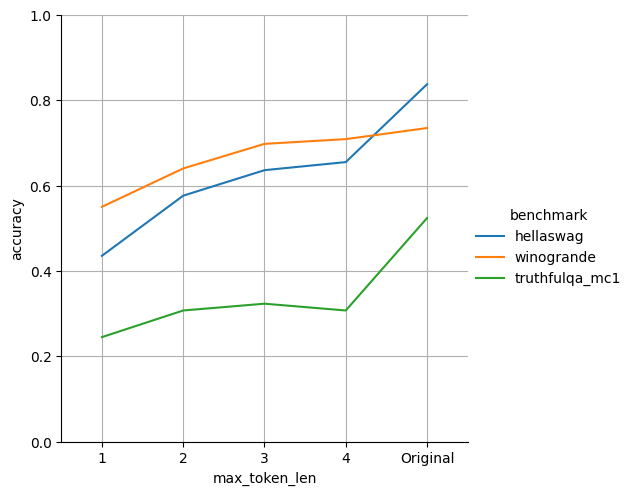

In [47]:
fig = plt.figure()
sns.relplot(
    data=results_df,
    # col='p_rate',
    y='accuracy',
    hue='benchmark',
    x='max_token_len',
    # size=...,
    # hue='iterative',
    style='model',
    kind='line',
    markers=True
    # row=...
    # xlim=[-0.1, 1.0],
    # ylim=[0.0, 1.1]
)
plt.xlim([0.5, 5.5])
plt.xticks(range(1, 6), [1,2,3,4,'Original'])
plt.ylim([0.0, 1.0])
# plt.hlines(0.8366859191396137, 0, 1, colors='g', linestyles='dashed', label='base_model')
plt.grid()
# plt.legend(loc='center')
plt.show()